In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse

def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new

In [3]:
data = pd.read_csv('TempLinkoping2016.txt', sep="\t")

time = np.atleast_2d(data["time"].values).T
temp = np.atleast_2d(data["temp"].values).T

In [6]:
X = time # fraction of the year [0, 1]
y = temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

n_samples, n_features = np.shape(X)

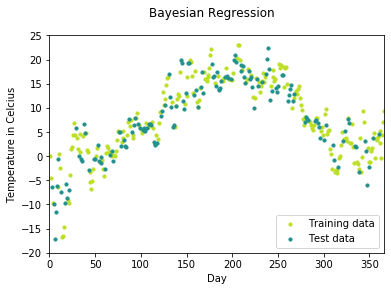

In [14]:
cmap = plt.get_cmap('viridis')

# Plot the results
m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
plt.axis((0, 366, -20, 25))
plt.suptitle("Bayesian Regression")
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
#plt.legend(loc='lower right')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
#plt.legend(loc='lower right')

plt.show()

In [10]:
# Prior parameters
# - Weights are assumed distr. according to a Normal distribution
# - The variance of the weights are assumed distributed according to 
#   a scaled inverse chi-squared distribution.
# High prior uncertainty!
# Normal
mu0 = np.array([0] * n_features)
omega0 = np.diag([.0001] * n_features)
# Scaled inverse chi-squared
nu0 = 1
sigma_sq0 = 100

# The credible interval
cred_int = 10

In [15]:
from __future__ import print_function, division
from scipy.stats import chi2, multivariate_normal

In [17]:

class BayesianRegression(object):
    """Bayesian regression model. If poly_degree is specified the features will
    be transformed to with a polynomial basis function, which allows for polynomial
    regression. Assumes Normal prior and likelihood for the weights and scaled inverse
    chi-squared prior and likelihood for the variance of the weights.

    Parameters:
    -----------
    n_draws: float
        The number of simulated draws from the posterior of the parameters.
    mu0: array
        The mean values of the prior Normal distribution of the parameters.
    omega0: array
        The precision matrix of the prior Normal distribution of the parameters.
    nu0: float
        The degrees of freedom of the prior scaled inverse chi squared distribution.
    sigma_sq0: float
        The scale parameter of the prior scaled inverse chi squared distribution.
    poly_degree: int
        The polynomial degree that the features should be transformed to. Allows
        for polynomial regression.
    cred_int: float
        The credible interval (ETI in this impl.). 95 => 95% credible interval of the posterior
        of the parameters.

    Reference:
        https://github.com/mattiasvillani/BayesLearnCourse/raw/master/Slides/BayesLearnL5.pdf
    """
    def __init__(self, n_draws, mu0, omega0, nu0, sigma_sq0, poly_degree=0, cred_int=95):
        self.w = None
        self.n_draws = n_draws
        self.poly_degree = poly_degree
        self.cred_int = cred_int

        # Prior parameters
        self.mu0 = mu0
        self.omega0 = omega0
        self.nu0 = nu0
        self.sigma_sq0 = sigma_sq0

    # Allows for simulation from the scaled inverse chi squared
    # distribution. Assumes the variance is distributed according to
    # this distribution.
    # Reference:
    #   https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution
    def _draw_scaled_inv_chi_sq(self, n, df, scale):
        X = chi2.rvs(size=n, df=df)
        sigma_sq = df * scale / X
        return sigma_sq

    def fit(self, X, y):

        # If polynomial transformation
        if self.poly_degree:
            X = polynomial_features(X, degree=self.poly_degree)

        n_samples, n_features = np.shape(X)

        X_X = X.T.dot(X)

        # Least squares approximate of beta
        beta_hat = np.linalg.pinv(X_X).dot(X.T).dot(y)

        # The posterior parameters can be determined analytically since we assume
        # conjugate priors for the likelihoods.

        # Normal prior / likelihood => Normal posterior
        mu_n = np.linalg.pinv(X_X + self.omega0).dot(X_X.dot(beta_hat)+self.omega0.dot(self.mu0))
        omega_n = X_X + self.omega0
        # Scaled inverse chi-squared prior / likelihood => Scaled inverse chi-squared posterior
        nu_n = self.nu0 + n_samples
        sigma_sq_n = (1.0/nu_n)*(self.nu0*self.sigma_sq0 + \
            (y.T.dot(y) + self.mu0.T.dot(self.omega0).dot(self.mu0) - mu_n.T.dot(omega_n.dot(mu_n))))

        # Simulate parameter values for n_draws
        beta_draws = np.empty((self.n_draws, n_features))
        for i in range(self.n_draws):
            sigma_sq = self._draw_scaled_inv_chi_sq(n=1, df=nu_n, scale=sigma_sq_n)
            beta = multivariate_normal.rvs(size=1, mean=mu_n[:,0], cov=sigma_sq*np.linalg.pinv(omega_n))
            # Save parameter draws
            beta_draws[i, :] = beta

        # Select the mean of the simulated variables as the ones used to make predictions
        self.w = np.mean(beta_draws, axis=0)

        # Lower and upper boundary of the credible interval
        l_eti = 50 - self.cred_int/2
        u_eti = 50 + self.cred_int/2
        self.eti = np.array([[np.percentile(beta_draws[:,i], q=l_eti), np.percentile(beta_draws[:,i], q=u_eti)] \
                                for i in range(n_features)])

    def predict(self, X, eti=False):

        # If polynomial transformation
        if self.poly_degree:
            X = polynomial_features(X, degree=self.poly_degree)

        y_pred = X.dot(self.w)
        # If the lower and upper boundaries for the 95%
        # equal tail interval should be returned
        if eti:
            lower_w = self.eti[:, 0]
            upper_w = self.eti[:, 1]
            y_lower_pred = X.dot(lower_w)
            y_upper_pred = X.dot(upper_w)
            return y_pred, y_lower_pred, y_upper_pred

        return y_pred


Mean Squared Error: 114.64803277947361


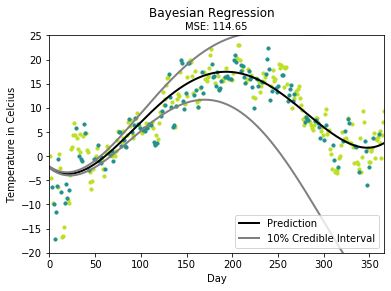

In [21]:

# Prior parameters
# - Weights are assumed distr. according to a Normal distribution
# - The variance of the weights are assumed distributed according to 
#   a scaled inverse chi-squared distribution.
# High prior uncertainty!
# Normal
mu0 = np.array([0] * n_features)
omega0 = np.diag([.0001] * n_features)
# Scaled inverse chi-squared
nu0 = 1
sigma_sq0 = 100

# The credible interval
cred_int = 10

clf = BayesianRegression(n_draws=2000, 
    poly_degree=4, 
    mu0=mu0, 
    omega0=omega0, 
    nu0=nu0, 
    sigma_sq0=sigma_sq0,
    cred_int=cred_int)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

# Get prediction line
y_pred_, y_lower_, y_upper_ = clf.predict(X=X, eti=True)

# Print the mean squared error
print ("Mean Squared Error:", mse)

# Color map
cmap = plt.get_cmap('viridis')

# Plot the results
m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
p1 = plt.plot(366 * X, y_pred_, color="black", linewidth=2, label="Prediction")
p2 = plt.plot(366 * X, y_lower_, color="gray", linewidth=2, label="{0}% Credible Interval".format(cred_int))
p3 = plt.plot(366 * X, y_upper_, color="gray", linewidth=2)
plt.axis((0, 366, -20, 25))
plt.suptitle("Bayesian Regression")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend(loc='lower right')
# plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.legend(loc='lower right')

plt.show()